In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from galaxy_analysis.analysis import PDF
import galaxy_analysis.utilities as galutil
#
# Andrew Wetzel's gizmo analysis code + helpful utilities
#
# Here:      https://bitbucket.org/awetzel/gizmo_analysis
# and here:  https://bitbucket.org/awetzel/utilities
#
#
import gizmo_analysis as gizmo
import utilities as gizmo_ut
from utilities.basic.binning import BinClass
from utilities.basic.constant import sun_composition

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()


#sun_composition = gizmo_ut.basic.constant.sun_composition

In [8]:
wdir = "/home/aemerick/work/gizmo_runs/metal_diff/m11q_res880"

#wdir = "/home/aemerick/work/gizmo_runs/m12q_res5700"

In [9]:
#
# First, lets grab a snapshot
#
sim_index = 600

part = gizmo.io.Read.read_snapshots(['star','gas'], # types of particles to load. Gas and/or stars
                                    'index',        # what the next value describes (check docstring for more)
                                    sim_index,      # simulation output index (nth output)
                                    assign_host_principal_axes=True,    # yes! compute the disk of the galaxy
                                    simulation_directory = wdir)

#
# (and for the sake of this analysis, I'm also grabbing the 1st snapshot, aka the initial conditions)
#    no stars in this one, so just need to get gas
#part0 = gizmo.io.Read.read_snapshots(['gas'], 'index', 0,
#                                    # assign_host_principal_axes=True, don't need to do this for this one
#                                    simulation_directory = wdir)


# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/metal_diff/m11q_res880/snapshot_times.txt

  using snapshot index = 600, redshift = 0.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/metal_diff/m11q_res880/output/snapdir_600/snapshot_600.0.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 129840464 particles
    dark2     (id = 2): 8997544 particles
    gas       (id = 0): 128788874 particles
    star      (id = 4): 1058548 particles
    blackhole (id = 5): 0 particles

* reading species: ['star', 'gas']
* reading particles from:
    snapshot_600.0.hdf5
    snapshot_600.1.hdf5
    snapshot_600.2.hdf5
    snapshot_600.3.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/metal_diff/m11q_res880/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.9

In [10]:
#
# This may not bethe same for all sims. But will be something like this:
#
#    load some information about the halo for this galaxy. This isn't strictly necessary, but
#    it is useful to know what the virial radius and mass are.
#
full_halo_data = np.genfromtxt(wdir + '/halo/snapshot_600.z0.000.AHF_halos',names=True)

# save some in a simple dict for z = 0 properties
#    first index of full halo data is the z=0 properties.
#    annoying integers in the names are the column numbers
#       Masses in (Msun), distances in kpc
halo_data = {'Mvir' :   full_halo_data['Mvir4'][0],
             'Rvir' :   full_halo_data['Rvir12'][0],
             'M_gas':   full_halo_data['M_gas45'][0],
             'M_star':  full_halo_data['M_star65'][0]}

for k in halo_data.keys():
    print (k,halo_data[k])
    
del(full_halo_data) # toss

Mvir 114537000000.0
Rvir 121.89
M_gas 4606950000.0
M_star 334462000.0


In [11]:
#
# For this analysis, I'm computing radial profiles. Define the ranges and bins
# 
r_min, r_max = 0.0, 1.0 # in units of R_vir
r_min = r_min * halo_data['Rvir'] # now in kpc
r_max = r_max * halo_data['Rvir']
nbins = 100
dr    = (r_max-r_min)/(float(nbins))

In [17]:
#
#
# Start binning ISM gas up by metallicity
#
#
element = 'o'
xfield  = 'metallicity.' + element
rvals  = part['gas'].prop('host.distance.principal.spherical')[:,0]
select = rvals < 0.025*r_max
xvals   =  part['gas'].prop(xfield)[select]
weights = ( part['gas'].prop('mass'))[select]


valmin = np.max([-8,np.min( xvals)]) - 0.001
valmax = np.max(xvals) + 0.001
    
print(valmin,valmax)
bc    = BinClass([valmin,valmax],number= int((valmax-valmin)/0.01))

hist = {}
stats = {}
fit={}

phasenames = {'CNM' : part['gas'].prop('temperature')[select] < 1000.0,
              'WNM' : (part['gas'].prop('temperature')[select] < 10000.0) * (part['gas'].prop('temperature')[select] > 1000.0),
              'WIM' : (part['gas'].prop('temperature')[select] < 1.0E5) * (part['gas'].prop('temperature')[select] > 10000.0),
              'HIM' : (part['gas'].prop('temperature')[select] < 1.0E10) * (part['gas'].prop('temperature')[select] > 1.0E5)}
              

#phasenames = {}

hist['total'] = bc.get_histogram(xvals,weights=weights)#,normed=True)
# some quantities must be computed in linear space (average of linear rather than average of log)
stats['total'] = galutil.utilities.compute_weighted_stats(10.0**(xvals),weights)

stats['total']['avg_mean'] = np.log10(np.sum(part['gas'].prop('mass.'+element)[select]) / np.sum(part['gas'].prop('mass.h')[select])) -\
                             np.log10(sun_composition[element]['massfraction']/sun_composition['h']['massfraction'])

fit_select = (bc.mids > np.log10(stats['total']['decile_1'])) * (bc.mids < np.log10(stats['total']['decile_9']))

fit_select = ((bc.mids > (bc.mids[np.argmax(hist['total'])])-0.5) * (bc.mids < bc.mids[np.argmax(hist['total'])]+0.5))
fit_y = hist['total'][  fit_select ][:-1]
fit_x = 10.0**(bc.mids[fit_select])

fit['total'] = PDF.fit_multifunction_PDF(fit_x, fit_y / np.sum(fit_y), data = stats['total'])
    


for phase in phasenames:
    pselect = phasenames[phase]
    hist[phase]  = bc.get_histogram(xvals[pselect],weights=weights[pselect])#,normed=True)
    stats[phase] = galutil.utilities.compute_weighted_stats(10.0**(xvals[pselect]),weights[pselect])
    stats[phase]['avg_mean'] = np.log10(np.sum(part['gas'].prop('mass.'+element)[select][pselect]) / np.sum(part['gas'].prop('mass.h')[select][pselect])) -\
                             np.log10(sun_composition[element]['massfraction']/sun_composition['h']['massfraction'])
    
    fit_select = (bc.mids > np.log10(stats[phase]['decile_1'])) * (bc.mids < np.log10(stats[phase]['decile_9']))

    fit_select = ((bc.mids > (bc.mids[np.argmax(hist[phase])])-0.5) * (bc.mids < bc.mids[np.argmax(hist[phase])]+0.5))
    fit_y = hist[phase][  fit_select ][:-1]
    fit_x = 10.0**(bc.mids[fit_select])

    fit[phase] = PDF.fit_multifunction_PDF(fit_x, fit_y / np.sum(fit_y), data = stats[phase])
        
    
    #fit[phase]   = PDF.fit_multifunction_PDF(10.0**(bc.mins), hist[phase][:-1],
    #                                         data = stats[phase])
    

            #function_to_fit='lognormal_powerlaw')    

-1.9880184659957885 1.1477959880828856
lognormal True
lognormal_powerlaw True
gaussian_powerlaw True
powerlaw True
lognormal True
lognormal_powerlaw True
gaussian_powerlaw True
powerlaw True
lognormal True
lognormal_powerlaw True
gaussian_powerlaw True
powerlaw True
lognormal True
lognormal_powerlaw True
gaussian_powerlaw True
powerlaw True
lognormal True
lognormal_powerlaw True
gaussian_powerlaw True
powerlaw True


In [ ]:
bc.mids[np.argmax(hist['total'])]

In [ ]:
m_total_hist   = np.sum(hist['total'])
m_total_actual = np.sum(part['gas'].prop('mass')[select])
print("hist actual total masses", m_total_hist, m_total_actual, m_total_actual / m_total_hist)

#
# checking median
#
median = np.log10(stats['total']['median'])
#median = stats['total']['median']
print("Median = %5.5E ---  f mass below = %.2f --- f mass above = %.2f"%(median,
                                                                     np.sum(part['gas'].prop('mass')[select*(part['gas'].prop(xfield)<median)])/m_total_actual,
                                                                     np.sum(part['gas'].prop('mass')[select*(part['gas'].prop(xfield)>median)])/m_total_actual))
average        = np.log10(stats['total']['mean'])
average_actual = np.log10(np.sum(part['gas'].prop('mass.o')[select]) / np.sum(part['gas'].prop('mass.h')[select])) -\
                 np.log10(sun_composition['o']['massfraction']/sun_composition['h']['massfraction'])

print("Mean = %5.5E ---  f mass below = %.2f --- f mass above = %.2f"%(average,
                                                                     np.sum(part['gas'].prop('mass')[select*(part['gas'].prop(xfield)<average)])/m_total_actual,
                                                                     np.sum(part['gas'].prop('mass')[select*(part['gas'].prop(xfield)>average)])/m_total_actual))
print(average, average_actual)  

print(average, stats['total']['avg_mean'])

In [ ]:
print(part['gas'].prop('metallicity.o')[0])

print(10.0**(part['gas'].prop('metallicity.o')[0] + np.log10(0.00865/0.7)))

print("mass fraction (O/H) and (O/total)")
print(part['gas'].prop('mass.o')[0]/part['gas'].prop('mass.h')[0])
print(part['gas'].prop('mass.o')[0]/part['gas'].prop('mass')[0])

print("abundance ratio (O/H)")
print(part['gas'].prop('mass.o')[0]/part['gas'].prop('mass.h')[0] / 16.0)

print("mass ratio - solar mass fraction")
print(np.log10(part['gas'].prop('mass.o')[0]/part['gas'].prop('mass.h')[0]) - np.log10(0.0057379))
print(np.log10(part['gas'].prop('mass.o')[0]/part['gas'].prop('mass.h')[0]) - np.log10(0.0057379/0.7381))


In [ ]:
print(average)
print(average_actual)
print(np.log10(average_actual) - np.log10(0.00865/0.73))


Text(0.5, 0, '[O/H]')

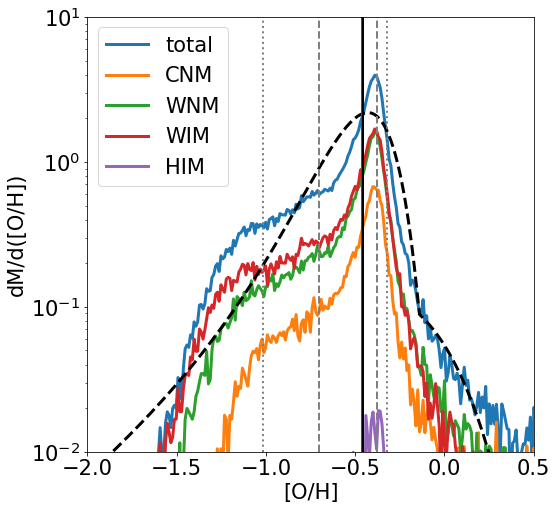

In [21]:
fig,ax=plt.subplots()
fig.set_size_inches(8,8)

#for phase in ['total'] + list(phasenames.keys()):
#    ax.plot(bc.mids, hist[phase] /np.sum(hist['total']), label=phase, lw = 3)

peaky = 1.0
#peaky = np.max(fit['total']['norm_y'])
dz_dlogznorm = 1.0/(np.log10(np.e) / 10.0**bc.mids[:-1])
db    = 10.0**bc.maxs - 10.0**bc.mins
dlogb = bc.maxs-bc.mins

for phase in ['total'] + list(phasenames.keys()):
    ax.plot(bc.mids, hist[phase] / np.sum(hist['total']) / dlogb, lw = 3, label = phase)
    
ax.plot(bc.mids[:-1],
        fit['total']['fit_result'](10.0**bc.mids[:-1])/peaky*dz_dlogznorm, lw = 3, color = 'black',ls='--')
        #fit['total']['fit_y']  * fit['total']['fit_x'] / np.max(fit['total']['fit_y'] * fit['total']['fit_x'] ) * np.max(hist['total']) / np.sum(hist['total']), lw = 3, color = 'black', ls = '--')

ax.set_ylim(0.01,10)

plot_idr = True
for phase in ['total']:
    ax.plot([stats[phase]['avg_mean']]*2, ax.get_ylim(), lw = 2, ls ='-', color = 'red')
    ax.plot([np.log10(stats[phase]['decile_1'])]*2, ax.get_ylim(), lw = 2, ls = ':', color = 'grey')
    ax.plot([np.log10(stats[phase]['decile_9'])]*2, ax.get_ylim(), lw = 2, ls = ':', color = 'grey')
    ax.plot([np.log10(stats[phase]['Q1'])]*2, ax.get_ylim(), lw = 2, ls = '--', color = 'grey')
    ax.plot([np.log10(stats[phase]['Q3'])]*2, ax.get_ylim(), lw = 2, ls = '--', color = 'grey')
    ax.plot([np.log10(stats[phase]['median'])]*2, ax.get_ylim(), lw = 2, ls = '-', color = 'black')

    
#db = bc.maxs - bc.mins
#ax.plot(bc.mids,  hist['total'] / np.sum(hist['total']) / db)
#ax.plot(bc.mids,  hist['total'] / np.sum(hist['total']) / db / 10.0**bc.mids * np.log10(np.e))
    
    
ax.legend(loc='best')
ax.semilogy()
ax.set_xlim(-2,0.5)


ax.set_ylabel('dM/d([O/H])')
ax.set_xlabel('[O/H]')

In [24]:
print(np.log10(stats['total']['median']))
print(stats['total']['avg_mean'])

-0.4553619567165157
-0.46353719371698254


In [ ]:
fit = PDF.fit_multifunction_PDF(10.0**(bc.mins), hist['total'][:-1],
            data = stats['total'])
            #function_to_fit='lognormal_powerlaw')

In [ ]:
#
# Now, lets create radial profiles of the TOTAL metal mass
#
#   Use A. Wetzel's binning utilitis
#

fields = ['mass','mass.metals','mass.si','mass.o','mass.c','mass.fe']

# profiling utilitiy
SpeciesProfile = gizmo_ut.particle.SpeciesProfileClass(
                 scaling = 'linear', limits=[r_min,r_max], width=dr,
                 dimension_number=3)

profile = {}
norm_dict = {}
initial_dict = {}
for field in fields:
    profile[field] = SpeciesProfile.get_profiles(part, species=['gas','star'], property_name=field,
                                                    property_statistic='sum',
                                                    # property_select = select_dict,
                                                    weight_by_mass = False)
    
    # compute the initial amount of these fields
    initial_dict[field] = np.sum(part0['gas'].prop(field))
    
    #
    # compute the normalization (total amount produced by stars in the sim)
    # so we need to also subtract out the amount initially present
    norm_dict[field]    = np.sum(part['star'].prop(field)) + np.sum(part['gas'].prop(field)) -\
                          initial_dict[field]
    

In [ ]:
plot_settings()
fig,ax=plt.subplots()
fig.set_size_inches(8,8)
field = 'mass.fe'

normplot = np.cumsum( profile[field]['gas']['sum'] + profile[field]['star']['sum'] )

norm = norm_dict[field]

for ptype in ['star','gas']:
    ax.plot( profile[field][ptype]['distance']/halo_data['Rvir'],
             np.cumsum(profile[field][ptype]['sum']) / norm, label = ptype, lw = 3)
    
ax.plot( profile[field]['star']['distance']/halo_data['Rvir'],
             normplot/norm, label = 'total', color = 'black', lw = 3)
        
ax.set_ylim(0.01,1.0)
ax.set_xlim(0.01,1.0) 
#
#
#
ax.plot([0.1,0.1],ax.get_ylim(),color='black',lw=2,ls='--')

ax.plot(ax.get_xlim(),[0.05,0.05],color='black',lw=2,ls=':')
ax.plot(ax.get_xlim(),[0.20,0.20],color='black',lw=2,ls=':')
    
    
ax.legend(loc='best')

ax.semilogy()
ax.semilogx()

ax.set_ylabel(r'Fractional Metal Mass')
ax.set_xlabel(r"Radius (R$_{\rm vir}$)")


Mgas = np.sum(profile['mass']['gas']['sum'][profile['mass']['gas']['distance'] < 0.1*halo_data['Rvir']])
Mstar = np.sum(profile['mass']['star']['sum'][profile['mass']['star']['distance'] < 0.1*halo_data['Rvir']])

xy = (0.02,0.95)
ax.annotate(r'M$_{*}$   = %4.2E M$_{\odot}$'%(Mstar),xy,xy,xycoords='axes fraction')
xy = (0.02,0.88)
ax.annotate(r'M$_{\rm gas}$ = %4.2E M$_{\odot}$'%(Mgas),xy,xy,xycoords='axes fraction')
xy = (0.02,0.81)
ax.annotate(r'R$_{\rm vir}$  = %.2f kpc'%(halo_data['Rvir']),xy,xy,xycoords='axes fraction')


ax.annotate(r"20%", (0.012,0.22),(0.012,0.22))
ax.annotate(r"5%", (0.012,0.052),(0.012,0.052))

plt.tight_layout()

fig.savefig(wdir + '/m11q_res880_metaldiff.png')

In [ ]:
np.sum(profile['mass']['gas']['sum'][profile['mass']['gas']['distance'] < 4]) / 1.0E8

In [ ]:
si_total = np.sum(part['gas'].prop('mass.si')) + np.sum(part['star'].prop('mass.si'))

si_yield = si_total / np.sum(part['star'].prop('mass'))

print(si_total)
print(si_yield)